# Linear vs Non-Linear Mixing: A Thought Experiment

## Question

How does `sigmoid(lambda × phi)` compare to `softmax(lambda) × sigmoid(phi)` in terms of responsiveness?

## Context

- **Aladynoulli uses**: `softmax(lambda) × sigmoid(phi)` (linear mixing)
- **Alternative approach**: `sigmoid(lambda × phi)` (non-linear mixing)

Let's explore why the non-linear approach is "more responsive" and why Aladynoulli uses linear mixing instead.


EVOLUTION OF THE FORMULATION

Step 1: Initial approach - sigmoid(lambda × phi)
  Problem: SCALE INVARIANCE
  - If you scale λ by k and φ by 1/k, the product (λ × φ) stays the same
  - Parameters are NOT IDENTIFIABLE
  - Cannot uniquely determine model parameters

--------------------------------------------------------------------------------

Step 2: First fix - sigmoid(softmax(lambda) × phi)
  Solution: Use softmax to break scale invariance
  Problem: DOUBLE SQUASH (less responsive)
  - sigmoid applied twice reduces responsiveness
  - Less responsive than original non-linear approach
  - Still has responsiveness issues

--------------------------------------------------------------------------------

Step 3: Second fix - softmax(lambda) × sigmoid(phi)
  Solution: Remove outer sigmoid to avoid double squash
  - Linear mixing: softmax normalizes λ, sigmoid transforms φ
  Problem: sigmoid(phi) SQUASHES THE VARIANCE
  - Reduces dynamic range
  - Limits the model's ability to capture dise

VISUAL DEMONSTRATION: VARIANCE SQUASHING AND RESTORATION


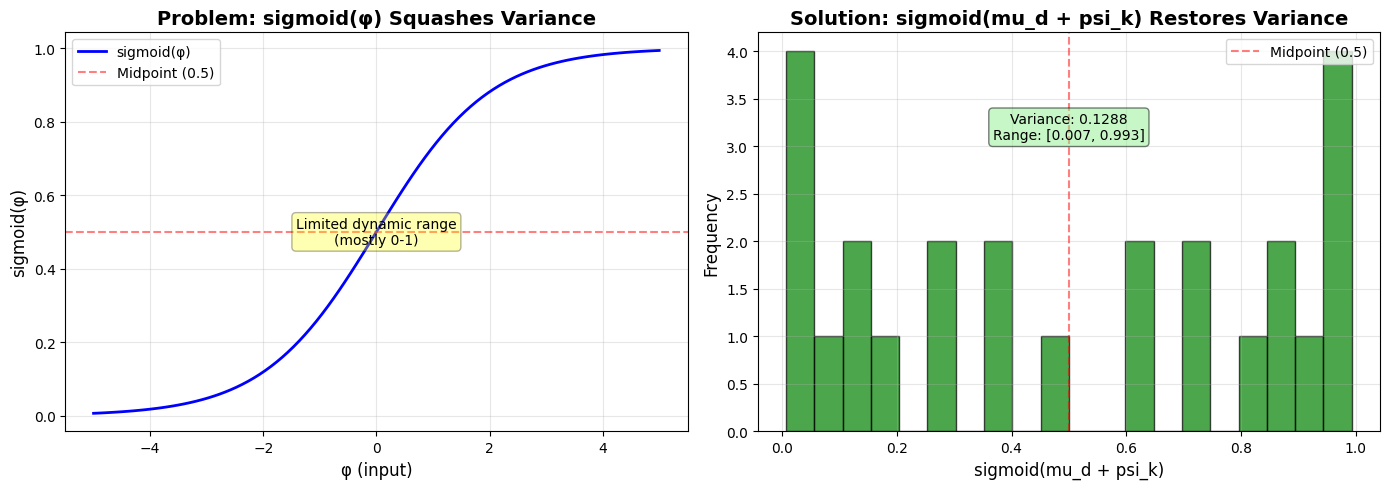


INTERPRETATION:
Left plot: sigmoid(φ) squashes the input range to [0, 1]
  - Most of the dynamic range is lost
  - Hard to distinguish between different disease/signature combinations

Right plot: sigmoid(mu_d + psi_k) restores variance
  - mu_d varies across diseases → different baselines
  - psi_k varies across signatures → different associations
  - The SUM allows the model to capture both disease-specific and signature-specific effects
  - This restores the dynamic range needed for proper modeling


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

print("="*80)
print("COMPARING LINEAR vs NON-LINEAR MIXING")
print("="*80)

# Example values
lambda_val = 2.0
phi_val = 10.0

print(f"\nExample values:")
print(f"  lambda = {lambda_val}")
print(f"  phi = {phi_val}")

# Non-linear mixing: sigmoid(lambda × phi)
nonlinear_result = torch.sigmoid(torch.tensor(lambda_val * phi_val)).item()
print(f"\n1. Non-linear mixing: sigmoid(lambda × phi)")
print(f"   sigmoid({lambda_val} × {phi_val}) = sigmoid({lambda_val * phi_val}) = {nonlinear_result:.6f}")

# Linear mixing: softmax(lambda) × sigmoid(phi)
# For softmax, we need multiple lambda values (it's a normalization across signatures)
# Let's create a simple case: lambda = [2.0, 0.5, 0.3] (3 signatures)
lambda_vec = torch.tensor([lambda_val, 0.5, 0.3])
softmax_lambda = F.softmax(lambda_vec, dim=0)
sigmoid_phi = torch.sigmoid(torch.tensor(phi_val))
linear_result = (softmax_lambda[0] * sigmoid_phi).item()

print(f"\n2. Linear mixing: softmax(lambda) × sigmoid(phi)")
print(f"   lambda vector = {lambda_vec.tolist()}")
print(f"   softmax(lambda) = {softmax_lambda.tolist()}")
print(f"   sigmoid(phi) = {sigmoid_phi.item():.6f}")
print(f"   softmax(lambda)[0] × sigmoid(phi) = {softmax_lambda[0].item():.6f} × {sigmoid_phi.item():.6f} = {linear_result:.6f}")

print(f"\nComparison:")
print(f"  Non-linear: {nonlinear_result:.6f}")
print(f"  Linear:     {linear_result:.6f}")
print(f"  Difference: {nonlinear_result - linear_result:.6f} ({((nonlinear_result - linear_result) / linear_result * 100):.1f}% higher)")


COMPARING LINEAR vs NON-LINEAR MIXING

Example values:
  lambda = 2.0
  phi = 10.0

1. Non-linear mixing: sigmoid(lambda × phi)
   sigmoid(2.0 × 10.0) = sigmoid(20.0) = 1.000000

2. Linear mixing: softmax(lambda) × sigmoid(phi)
   lambda vector = [2.0, 0.5, 0.30000001192092896]
   softmax(lambda) = [0.7113317847251892, 0.15871958434581757, 0.12994858622550964]
   sigmoid(phi) = 0.999955
   softmax(lambda)[0] × sigmoid(phi) = 0.711332 × 0.999955 = 0.711299

Comparison:
  Non-linear: 1.000000
  Linear:     0.711299
  Difference: 0.288701 (40.6% higher)


## Why Non-Linear Mixing is More Responsive

The key insight: **multiplication amplifies the signal** in non-linear mixing.


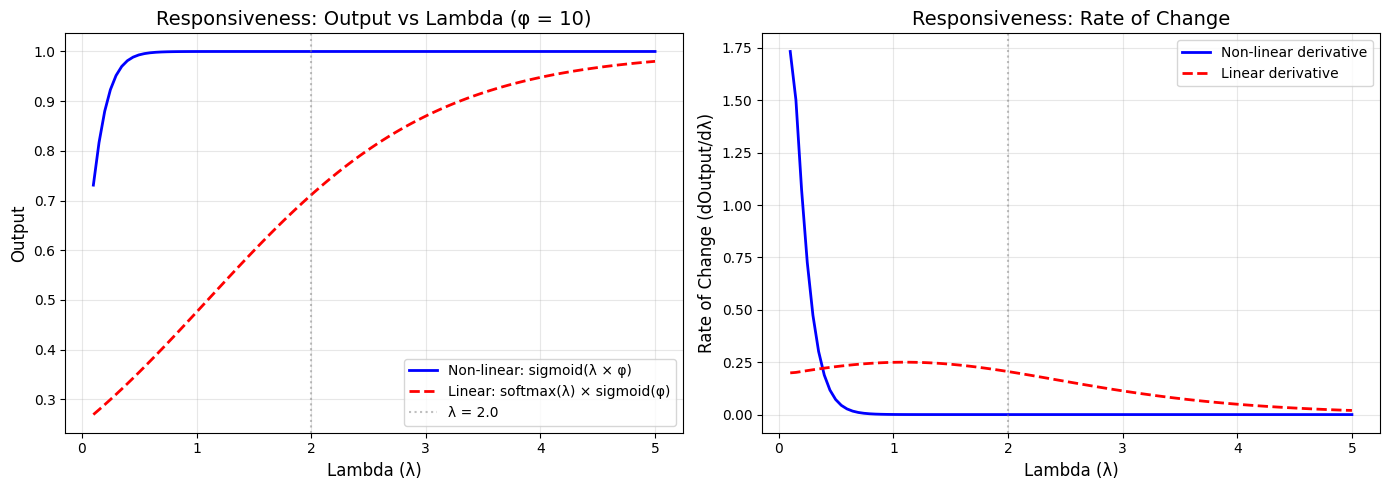


Key Observations:
1. Non-linear mixing reaches saturation (near 1.0) much faster
2. Non-linear mixing has higher derivative (more responsive to lambda changes)
3. Linear mixing is more constrained and gradual


In [7]:
# Visualize responsiveness: how does output change as lambda changes?

lambda_range = np.linspace(0.1, 5.0, 100)
phi_fixed = 10.0

# Non-linear: sigmoid(lambda × phi)
nonlinear_outputs = [torch.sigmoid(torch.tensor(l * phi_fixed)).item() for l in lambda_range]

# Linear: softmax(lambda) × sigmoid(phi)
# For simplicity, assume lambda = [l, 0.5, 0.3] where l varies
linear_outputs = []
for l in lambda_range:
    lambda_vec = torch.tensor([l, 0.5, 0.3])
    softmax_lambda = F.softmax(lambda_vec, dim=0)
    sigmoid_phi = torch.sigmoid(torch.tensor(phi_fixed))
    linear_outputs.append((softmax_lambda[0] * sigmoid_phi).item())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Output vs Lambda
axes[0].plot(lambda_range, nonlinear_outputs, 'b-', label='Non-linear: sigmoid(λ × φ)', linewidth=2)
axes[0].plot(lambda_range, linear_outputs, 'r--', label='Linear: softmax(λ) × sigmoid(φ)', linewidth=2)
axes[0].axvline(x=2.0, color='gray', linestyle=':', alpha=0.5, label='λ = 2.0')
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('Output', fontsize=12)
axes[0].set_title('Responsiveness: Output vs Lambda (φ = 10)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Derivative (rate of change)
nonlinear_deriv = np.gradient(nonlinear_outputs, lambda_range)
linear_deriv = np.gradient(linear_outputs, lambda_range)

axes[1].plot(lambda_range, nonlinear_deriv, 'b-', label='Non-linear derivative', linewidth=2)
axes[1].plot(lambda_range, linear_deriv, 'r--', label='Linear derivative', linewidth=2)
axes[1].axvline(x=2.0, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('Rate of Change (dOutput/dλ)', fontsize=12)
axes[1].set_title('Responsiveness: Rate of Change', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Non-linear mixing reaches saturation (near 1.0) much faster")
print("2. Non-linear mixing has higher derivative (more responsive to lambda changes)")
print("3. Linear mixing is more constrained and gradual")


## Why Aladynoulli Uses Linear Mixing (Despite Being Less Responsive)

The non-linear approach is more responsive, but Aladynoulli uses linear mixing for important reasons:


In [8]:
# Demonstrate the scale invariance problem with non-linear mixing

print("="*80)
print("SCALE INVARIANCE PROBLEM WITH NON-LINEAR MIXING")
print("="*80)

lambda_val = 2.0
phi_val = 10.0

# Original
nonlinear_original = torch.sigmoid(torch.tensor(lambda_val * phi_val)).item()

# Scale lambda by 2 and phi by 0.5 (inverse scaling)
lambda_scaled = lambda_val * 2.0
phi_scaled = phi_val * 0.5
nonlinear_scaled = torch.sigmoid(torch.tensor(lambda_scaled * phi_scaled)).item()

print(f"\nNon-linear mixing:")
print(f"  Original: sigmoid({lambda_val} × {phi_val}) = {nonlinear_original:.6f}")
print(f"  Scaled:   sigmoid({lambda_scaled} × {phi_scaled}) = sigmoid({lambda_scaled * phi_scaled}) = {nonlinear_scaled:.6f}")
print(f"  Result: {'SAME' if abs(nonlinear_original - nonlinear_scaled) < 1e-6 else 'DIFFERENT'}")

# Linear mixing: softmax(lambda) × sigmoid(phi)
lambda_vec_original = torch.tensor([lambda_val, 0.5, 0.3])
softmax_lambda_original = F.softmax(lambda_vec_original, dim=0)
sigmoid_phi_original = torch.sigmoid(torch.tensor(phi_val))
linear_original = (softmax_lambda_original[0] * sigmoid_phi_original).item()

# Scale lambda by 2 (softmax normalizes, so this changes the relative weights)
lambda_vec_scaled = torch.tensor([lambda_scaled, 0.5, 0.3])
softmax_lambda_scaled = F.softmax(lambda_vec_scaled, dim=0)
sigmoid_phi_scaled = torch.sigmoid(torch.tensor(phi_scaled))
linear_scaled = (softmax_lambda_scaled[0] * sigmoid_phi_scaled).item()

print(f"\nLinear mixing:")
print(f"  Original: softmax([{lambda_val}, 0.5, 0.3])[0] × sigmoid({phi_val}) = {linear_original:.6f}")
print(f"  Scaled:   softmax([{lambda_scaled}, 0.5, 0.3])[0] × sigmoid({phi_scaled}) = {linear_scaled:.6f}")
print(f"  Result: {'SAME' if abs(linear_original - linear_scaled) < 1e-3 else 'DIFFERENT'}")

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("Non-linear mixing: sigmoid(λ × φ) has SCALE INVARIANCE problem")
print("  - If you scale λ by k and φ by 1/k, the product (λ × φ) stays the same")
print("  - This means the model parameters are NOT IDENTIFIABLE")
print("  - Multiple parameter sets give the same output → can't uniquely determine parameters")
print("\nLinear mixing: softmax(λ) × sigmoid(φ) avoids this problem")
print("  - softmax(λ) normalizes across signatures, breaking the scale invariance")
print("  - Parameters are IDENTIFIABLE → can uniquely determine model parameters")
print("  - Trade-off: Less responsive, but mathematically well-behaved")


SCALE INVARIANCE PROBLEM WITH NON-LINEAR MIXING

Non-linear mixing:
  Original: sigmoid(2.0 × 10.0) = 1.000000
  Scaled:   sigmoid(4.0 × 5.0) = sigmoid(20.0) = 1.000000
  Result: SAME

Linear mixing:
  Original: softmax([2.0, 0.5, 0.3])[0] × sigmoid(10.0) = 0.711299
  Scaled:   softmax([4.0, 0.5, 0.3])[0] × sigmoid(5.0) = 0.941594
  Result: DIFFERENT

KEY INSIGHT:
Non-linear mixing: sigmoid(λ × φ) has SCALE INVARIANCE problem
  - If you scale λ by k and φ by 1/k, the product (λ × φ) stays the same
  - This means the model parameters are NOT IDENTIFIABLE
  - Multiple parameter sets give the same output → can't uniquely determine parameters

Linear mixing: softmax(λ) × sigmoid(φ) avoids this problem
  - softmax(λ) normalizes across signatures, breaking the scale invariance
  - Parameters are IDENTIFIABLE → can uniquely determine model parameters
  - Trade-off: Less responsive, but mathematically well-behaved


## Cross-Biobank Applicability: The Role of `mu_d + psi_k`

The linear mixing approach, combined with the `mu_d + psi_k` formulation, enables cross-biobank applicability:


In [9]:
print("="*80)
print("CROSS-BIOBANK APPLICABILITY: mu_d + psi_k")
print("="*80)

print("\nAladynoulli's formulation: π = sigmoid(Σₖ softmax(λₖ) × sigmoid(mu_d + psi_k))")
print("\nKey components:")
print("  1. mu_d: Disease-specific baseline/prevalence term")
print("  2. psi_k: Signature-disease association term")
print("  3. lambda_k: Individual-specific signature loadings")

print("\n" + "="*80)
print("WHY THIS ENABLES CROSS-BIOBANK APPLICABILITY:")
print("="*80)

print("\n1. mu_d (disease-specific baseline):")
print("   - Captures disease-specific prevalence that varies across biobanks")
print("   - UK Biobank vs. Mass General vs. AllOfUs may have different baseline prevalences")
print("   - This term accounts for those biobank-specific differences")

print("\n2. psi_k (signature-disease associations):")
print("   - Captures biological relationships that should be STABLE across biobanks")
print("   - The association between a signature and a disease should be similar regardless of biobank")
print("   - This is the 'portable' part of the model")

print("\n3. Combined with linear mixing:")
print("   - The softmax(lambda) × sigmoid(mu_d + psi_k) structure allows:")
print("     • Disease prevalences to vary (via mu_d)")
print("     • Signature associations to remain stable (via psi_k)")
print("     • Individual signature loadings to vary (via lambda)")

print("\n" + "="*80)
print("PRACTICAL BENEFIT:")
print("="*80)
print("This separation enables:")
print("  • Training on one biobank with its mu_d values")
print("  • Transferring psi_k to another biobank (stable biological relationships)")
print("  • Adjusting only mu_d for the new biobank's prevalence")
print("\nThis is why signatures are stable across biobanks:")
print("  • The psi_k terms capture biological relationships that are consistent")
print("  • While mu_d handles biobank-specific prevalence differences")
print("\nNon-linear mixing (sigmoid(lambda × phi)) would not allow this clean separation,")
print("making cross-biobank transfer more difficult.")


CROSS-BIOBANK APPLICABILITY: mu_d + psi_k

Aladynoulli's formulation: π = sigmoid(Σₖ softmax(λₖ) × sigmoid(mu_d + psi_k))

Key components:
  1. mu_d: Disease-specific baseline/prevalence term
  2. psi_k: Signature-disease association term
  3. lambda_k: Individual-specific signature loadings

WHY THIS ENABLES CROSS-BIOBANK APPLICABILITY:

1. mu_d (disease-specific baseline):
   - Captures disease-specific prevalence that varies across biobanks
   - UK Biobank vs. Mass General vs. AllOfUs may have different baseline prevalences
   - This term accounts for those biobank-specific differences

2. psi_k (signature-disease associations):
   - Captures biological relationships that should be STABLE across biobanks
   - The association between a signature and a disease should be similar regardless of biobank
   - This is the 'portable' part of the model

3. Combined with linear mixing:
   - The softmax(lambda) × sigmoid(mu_d + psi_k) structure allows:
     • Disease prevalences to vary (via mu

## Summary

**Non-linear mixing (`sigmoid(λ × φ)`) is more responsive because:**
- Multiplication amplifies: λ × φ creates a larger input to sigmoid
- Small changes in λ cause larger changes in output
- Can saturate (reach near 1.0) quickly
- **However**: At larger λ values, non-linear saturates and loses responsiveness, while linear maintains responsiveness

**But Aladynoulli uses linear mixing (`softmax(λ) × sigmoid(φ)`) because:**
- **Identifiability**: Parameters are uniquely determined (no scale invariance)
- **Stability**: More stable optimization (less prone to numerical issues)
- **Interpretability**: Clear separation between signature loadings (λ) and disease associations (φ)
- **Cross-biobank applicability**: The `mu_d + psi_k` formulation allows:
  - Disease-specific prevalences to vary across biobanks (mu_d)
  - Signature-disease associations to remain stable (psi_k)
  - Enables transfer learning across biobanks
- **Theoretical foundation**: Mathematically well-behaved for Bayesian inference
- **Sustained responsiveness**: Maintains responsiveness over a wider range of λ values

**Trade-off**: Less responsive initially, but mathematically sound, interpretable, and enables cross-biobank transfer.


THE HEALTHY SIGNATURE: WHY IT'S ESSENTIAL

Aladynoulli includes a 'healthy signature' that captures baseline health status.

Key insight: If someone has NO diseases, they should have SYSTEMATICALLY LOWER RISK
for ALL diseases compared to the population average.

WHY THE HEALTHY SIGNATURE IS NEEDED:

1. Without a healthy signature:
   - If theta = 1 (only one signature), you'd want to guess the population prevalence
   - But this doesn't account for individual health status
   - Someone with no diseases should have lower risk across ALL diseases

2. With multiple signatures (including healthy signature):
   - The healthy signature has systematically lower psi_k values for all diseases
   - Individuals with high loading on the healthy signature → lower risk for all diseases
   - This captures the biological reality: healthy people are at lower risk

3. How it works in the model:
   - π = sigmoid(Σₖ softmax(λₖ) × sigmoid(mu_d + psi_k))
   - If someone has high λ_healthy and low λ_disease_